
# DỰ ÁN CÔNG TRƯỜNG THÔNG MINH

# PHÂN LOẠI HOẠT ĐỘNG MÁY XÚC

+ Remember: pip install bokeh

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Span, Toggle, Slider, CustomJS, Div
from bokeh.layouts import column, row

In [6]:
# ==== Đọc & chuẩn bị dữ liệu (chuyển giờ Việt Nam) ====
# Lưu ý: Timestamp gốc là UTC. Ta parse UTC và convert sang Asia/Ho_Chi_Minh.
df = pd.read_csv("../data/processed/08102022_data.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

##### Chuẩn Euclid của gia tốc
$$
\mathrm{acc\_{norm}}(i)=\left\lVert \mathbf{a}_i \right\rVert_2=\sqrt{a_{i,x}^2+a_{i,y}^2+a_{i,z}^2}
$$

- Gia tốc càng lớn, chuyển động càng nhanh.

##### Chuẩn Euclid của gyro
$$
\mathrm{gyro\_{norm}}(i)=\sqrt{\mathrm{Gyro\_x}(i)^2+\mathrm{Gyro\_y}(i)^2+\mathrm{Gyro\_z}(i)^2}
$$

- Gyro càng lớn, hoạt động xoay càng nhanh.

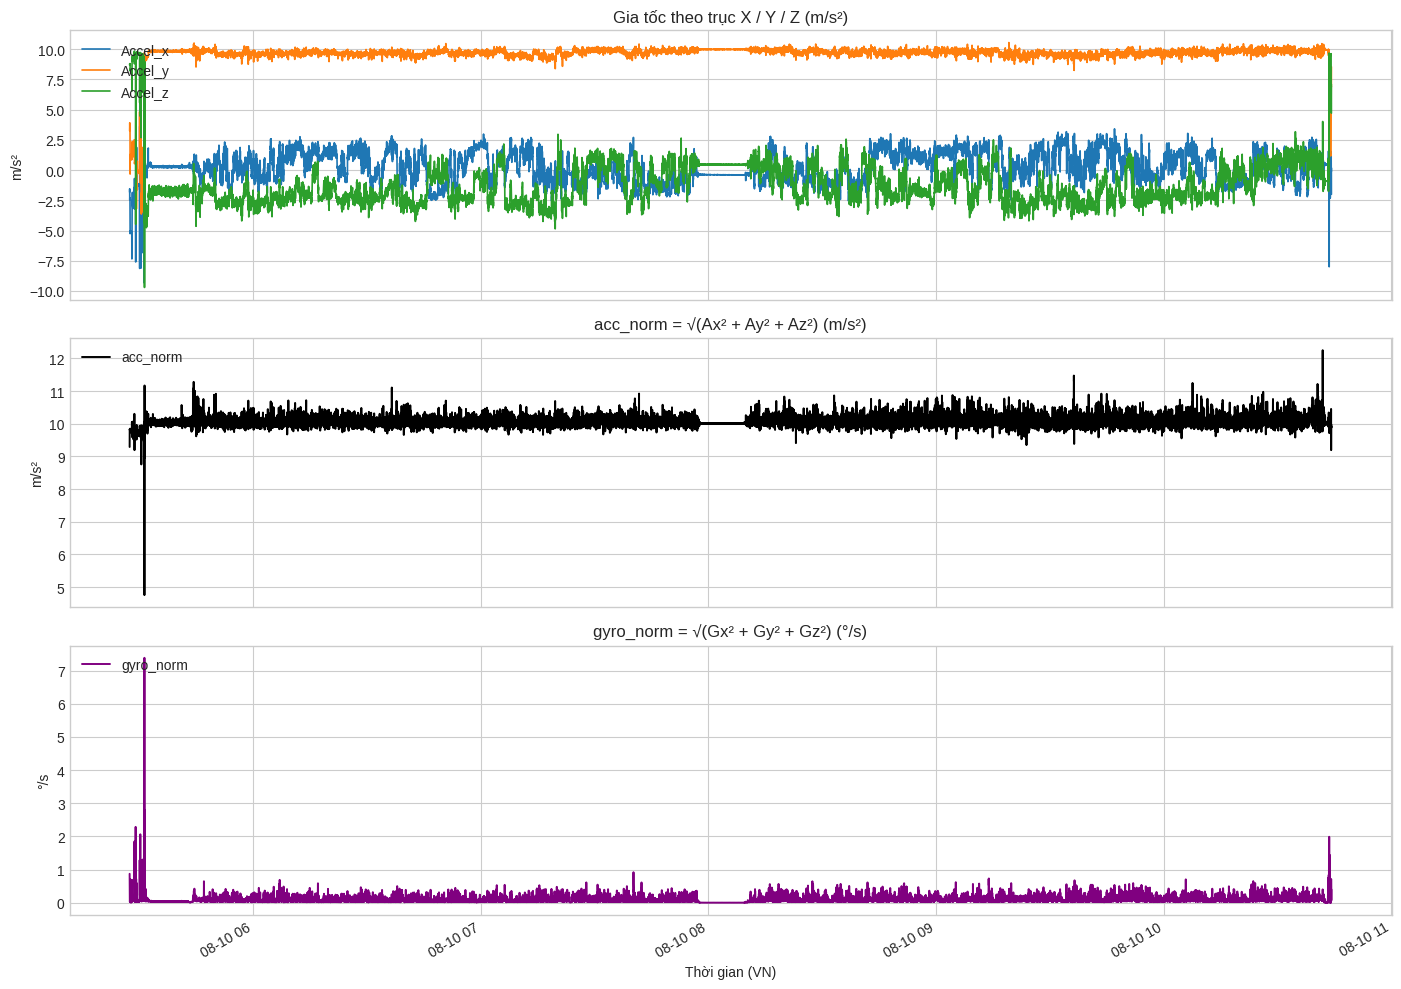

In [7]:
# 0) Tính acc_norm và gyro_norm (chuẩn Euclid của 3 trục)
df['acc_norm']  = np.linalg.norm(df[['Accel_x','Accel_y','Accel_z']].values, axis=1)
df['gyro_norm'] = np.linalg.norm(df[['Gyro_x','Gyro_y','Gyro_z']].values,  axis=1)

# 1) Làm sạch NaN/Inf/NaT cho các cột sẽ vẽ
cols_plot = ['Timestamp', 'Accel_x', 'Accel_y', 'Accel_z', 'acc_norm', 'gyro_norm']
df[cols_plot] = df[cols_plot].replace([np.inf, -np.inf], np.nan)
df_clean = df.dropna(subset=cols_plot).copy()

# 2) Resample 1s theo Timestamp (giảm kích thước & làm mượt)
cols_keep = ['Accel_x','Accel_y','Accel_z','acc_norm','gyro_norm']
df_small = (df_clean.set_index('Timestamp')[cols_keep]
            .resample('1s').median().dropna().reset_index())

# 3) Vẽ bằng matplotlib: 3 subplot – (1) Accel X/Y/Z, (2) acc_norm, (3) gyro_norm
plt.style.use('seaborn-v0_8-whitegrid')  # style seaborn tương thích MPL mới
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

# Subplot 1: Accel X/Y/Z
axes[0].plot(df_small['Timestamp'], df_small['Accel_x'], label='Accel_x', color='#1f77b4', linewidth=1.2)
axes[0].plot(df_small['Timestamp'], df_small['Accel_y'], label='Accel_y', color='#ff7f0e', linewidth=1.2)
axes[0].plot(df_small['Timestamp'], df_small['Accel_z'], label='Accel_z', color='#2ca02c', linewidth=1.2)
axes[0].set_title('Gia tốc theo trục X / Y / Z (m/s²)')
axes[0].set_ylabel('m/s²')
axes[0].legend(loc='upper left')

# Subplot 2: acc_norm
axes[1].plot(df_small['Timestamp'], df_small['acc_norm'], label='acc_norm', color='black', linewidth=1.4)
axes[1].set_title('acc_norm = √(Ax² + Ay² + Az²) (m/s²)')
axes[1].set_ylabel('m/s²')
axes[1].legend(loc='upper left')

# Subplot 3: gyro_norm
axes[2].plot(df_small['Timestamp'], df_small['gyro_norm'], label='gyro_norm', color='purple', linewidth=1.4)
axes[2].set_title('gyro_norm = √(Gx² + Gy² + Gz²) (°/s)')
axes[2].set_ylabel('°/s')
axes[2].set_xlabel('Thời gian (VN)')
axes[2].legend(loc='upper left')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

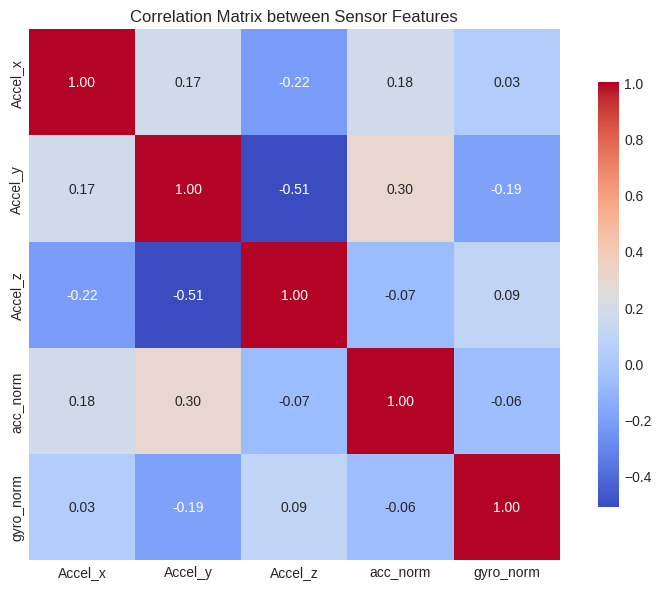

In [21]:
import seaborn as sns

# 5) Visualize correlation matrix between features
corr_features = ['Accel_x', 'Accel_y', 'Accel_z', 'acc_norm', 'gyro_norm']
corr = df_small[corr_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink':0.8})
plt.title("Correlation Matrix between Sensor Features")
plt.tight_layout()
plt.show()


In [8]:
acc_med  = np.median(df_small['acc_norm'].values)
gyro_med = np.median(df_small['gyro_norm'].values)
print("acc_med:", acc_med, "gyro_med:", gyro_med)

acc_med: 10.054913795010668 gyro_med: 0.06784175669572064


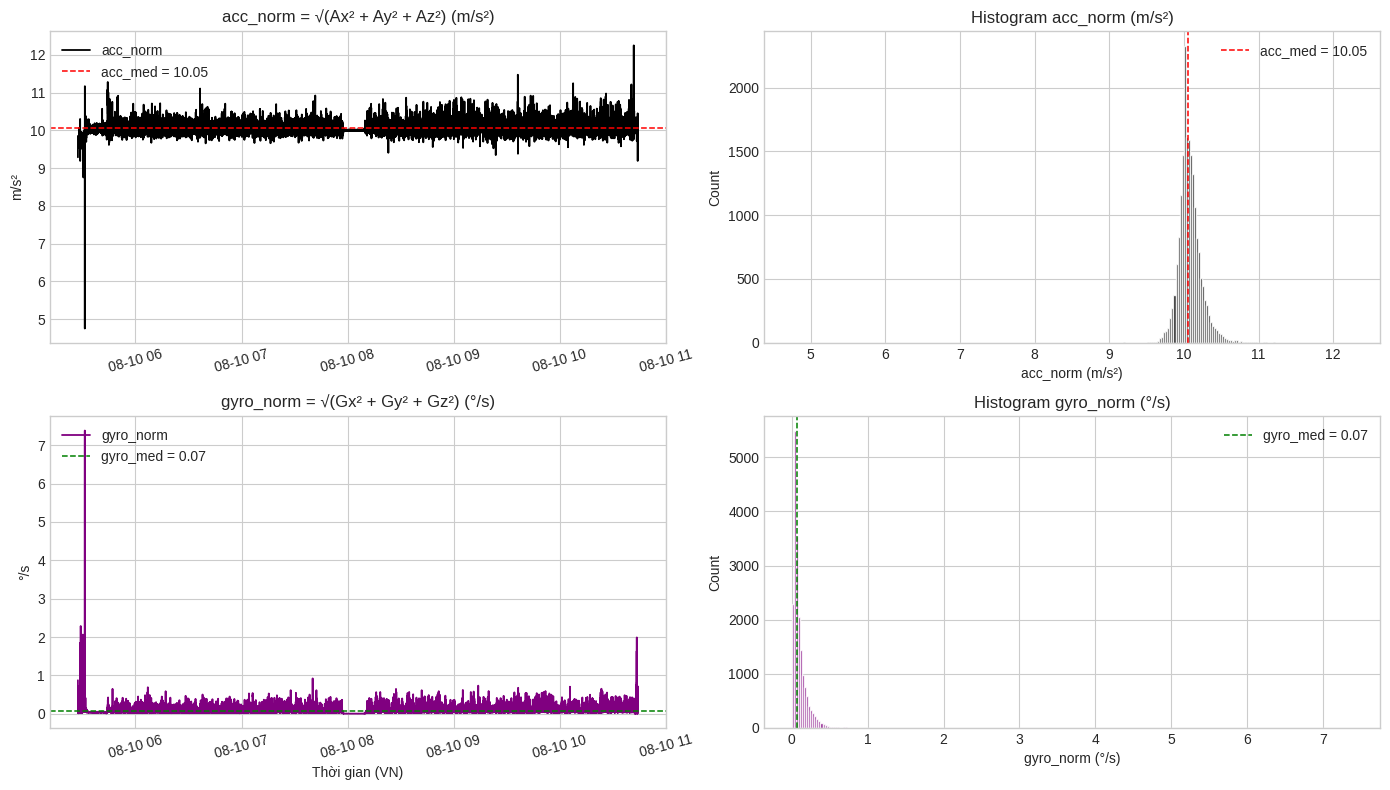

In [9]:
acc_med  = np.median(df_small['acc_norm'].values)
gyro_med = np.median(df_small['gyro_norm'].values)

# 4) Vẽ layout 2x2: bên trái time series, bên phải histogram
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharex=False)

# (1,1) Time series acc_norm
axes[0,0].plot(df_small['Timestamp'], df_small['acc_norm'],
               label='acc_norm', color='black', linewidth=1.3)
axes[0,0].axhline(acc_med, color='red', linestyle='--', linewidth=1.1,
                  label=f'acc_med = {acc_med:.2f}')
axes[0,0].set_title('acc_norm = √(Ax² + Ay² + Az²) (m/s²)')
axes[0,0].set_ylabel('m/s²')
axes[0,0].legend(loc='upper left')
for label in axes[0,0].get_xticklabels():
    label.set_rotation(15)

# (1,2) Histogram acc_norm
axes[0,1].hist(df_small['acc_norm'].values, bins='auto',
               color='black', alpha=0.85, edgecolor='white')
axes[0,1].axvline(acc_med, color='red', linestyle='--', linewidth=1.1,
                  label=f'acc_med = {acc_med:.2f}')
axes[0,1].set_title('Histogram acc_norm (m/s²)')
axes[0,1].set_xlabel('acc_norm (m/s²)')
axes[0,1].set_ylabel('Count')
axes[0,1].legend(loc='upper right')

# (2,1) Time series gyro_norm
axes[1,0].plot(df_small['Timestamp'], df_small['gyro_norm'],
               label='gyro_norm', color='purple', linewidth=1.3)
axes[1,0].axhline(gyro_med, color='green', linestyle='--', linewidth=1.1,
                  label=f'gyro_med = {gyro_med:.2f}')
axes[1,0].set_title('gyro_norm = √(Gx² + Gy² + Gz²) (°/s)')
axes[1,0].set_ylabel('°/s')
axes[1,0].set_xlabel('Thời gian (VN)')
axes[1,0].legend(loc='upper left')
for label in axes[1,0].get_xticklabels():
    label.set_rotation(15)

# (2,2) Histogram gyro_norm
axes[1,1].hist(df_small['gyro_norm'].values, bins='auto',
               color='purple', alpha=0.85, edgecolor='white')
axes[1,1].axvline(gyro_med, color='green', linestyle='--', linewidth=1.1,
                  label=f'gyro_med = {gyro_med:.2f}')
axes[1,1].set_title('Histogram gyro_norm (°/s)')
axes[1,1].set_xlabel('gyro_norm (°/s)')
axes[1,1].set_ylabel('Count')
axes[1,1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [10]:
acc_mad  = np.median(np.abs(df_small['acc_norm'].values - acc_med)) + 1e-6
gyro_mad = np.median(np.abs(df_small['gyro_norm'].values - gyro_med)) + 1e-6

# 2) Robust deviation Normalization
z_acc  = np.abs((df_small['acc_norm'].values  - acc_med)  / acc_mad)
z_gyro = np.abs((df_small['gyro_norm'].values - gyro_med) / gyro_mad)

activity_score = 0.7*z_acc + 0.3*z_gyro
df_small['activity_score'] = activity_score

$$ActivityScore=0.7*\dfrac{accel_norm - accel_median}{accel_median + 10^{-6}} + 0.3*\dfrac{gyro_norm - gyro_median}{gyro_median + 10^{-6}}$$

In [11]:
on_pct  = 75  # có thể thử 80
off_pct = 60  # có thể thử 65

on_th  = np.percentile(df_small['activity_score'].values, on_pct)
off_th = np.percentile(df_small['activity_score'].values, off_pct)

# fs sau resample
fs_ds = 1.0  # Hz
debounce_sec = 10.0 # Sau 10s không active chuyển sang idle
debounce_samples = int(round(debounce_sec * fs_ds))

states = []
active = False
below_count = 0

for s in df_small['activity_score'].values:
    if not active:
        if s > on_th:
            active = True
            below_count = 0
    else:
        if s < off_th:
            below_count += 1
            if below_count >= debounce_samples:
                active = False
                below_count = 0
        else:
            below_count = 0
    states.append(1 if active else 0)

df_small['active_cont'] = states

In [12]:
print(df_small.head())

                  Timestamp  Accel_x  Accel_y  Accel_z  acc_norm  gyro_norm  \
0 2022-08-10 05:27:26-07:00 -1.82025  3.25725  8.78970  9.288736   0.874657   
1 2022-08-10 05:27:27-07:00 -1.54720  3.81765  8.75380  9.832842   0.264270   
2 2022-08-10 05:27:28-07:00 -2.46930  3.91345  8.67715  9.806666   0.174667   
3 2022-08-10 05:27:29-07:00 -2.29440  3.68830  8.79690  9.813855   0.030756   
4 2022-08-10 05:27:30-07:00 -2.41900  3.80570  8.71790  9.814916   0.029578   

   activity_score  active_cont  
0       14.208709            1  
1        3.775726            1  
2        3.188533            1  
3        2.486087            1  
4        2.487420            1  


In [13]:
print(df.head())

                  Timestamp  Accel_x  Accel_y  Accel_z  Gyro_x  Gyro_y  \
0 2022-08-10 05:27:26-07:00  -1.8442   3.7027   8.2484  0.9552  0.7695   
1 2022-08-10 05:27:26-07:00  -2.5244   3.1997   8.1766  0.6026  0.8127   
2 2022-08-10 05:27:26-07:00  -2.9842   2.9315   8.9191  0.5349  1.0060   
3 2022-08-10 05:27:26-07:00  -1.6909   1.7388   8.8424  0.5333  0.9826   
4 2022-08-10 05:27:26-07:00  -1.1017   2.2178   8.2916  0.6755  0.5522   

   Gyro_z  acc_norm  gyro_norm  
0  0.3605  9.227522   1.278475  
1  0.5016  9.136053   1.129252  
2  0.0244  9.851370   1.139627  
3 -0.4454  9.169002   1.203450  
4 -1.7594  8.653497   1.963852  


In [14]:
acc_mad  = np.median(np.abs(df['acc_norm'].values - acc_med)) + 1e-6
gyro_mad = np.median(np.abs(df['gyro_norm'].values - gyro_med)) + 1e-6

# 2) Robust deviation Normalization
z_acc  = np.abs((df['acc_norm'].values  - acc_med)  / acc_mad)
z_gyro = np.abs((df['gyro_norm'].values - gyro_med) / gyro_mad)

activity_score = 0.7*z_acc + 0.3*z_gyro
df['activity_score'] = activity_score

In [20]:
# ==== Downsample 1 giây để giảm kích thước HTML (giữ đúng original UTC time) ====
cols_keep = ['activity_score','Accel_x','Accel_y','Accel_z','Gyro_x','Gyro_y','Gyro_z','acc_norm','gyro_norm']
# Set index as original UTC timestamp (no shift to local!)
df_ds = (df.set_index('Timestamp')[cols_keep]
           .resample('1s').median().dropna().reset_index())

# Đặt lại tên cột thời gian là 'Timestamp' (giữ UTC nguyên thủy)
# Các đoạn dưới dùng 'Timestamp' đúng theo raw ghi nhận

# ==== Hysteresis + trễ 10s khi chuyển về idle ====
on_th  = np.percentile(df_ds['activity_score'], 75)
off_th = np.percentile(df_ds['activity_score'], 60)

fs_ds = 1.0
debounce_sec = 10.0
debounce_samples = int(round(debounce_sec * fs_ds))

states = []
active = False
below_count = 0
for s in df_ds['activity_score']:
    if not active:
        if s > on_th:
            active = True
            below_count = 0
    else:
        if s < off_th:
            below_count += 1
            if below_count >= debounce_samples:
                active = False
                below_count = 0
        else:
            below_count = 0
    states.append(1 if active else 0)

df_ds['active_cont'] = states

# ==== Nguồn dữ liệu ====
source = ColumnDataSource(df_ds)

output_file("excavator_activity_continuous_with_raw_utc.html")

# ==== Điều khiển Play/Pause + tốc độ + thanh thời gian (ĐƯA LÊN TRÊN) ====
play_toggle = Toggle(label="Play", button_type="success", active=False)
speed_slider = Slider(title="Tốc độ phát (x)", start=0.25, end=4.0, step=0.25, value=1.0)
index_slider = Slider(title="Vị trí (mốc thời gian)", start=0, end=len(df_ds)-1, step=1, value=0)
status_text = Div(text="Paused")

# ==== Plot 1: Activity score + thresholds (UTC) ====
p1 = figure(x_axis_type='datetime', width=1100, height=260, title="Activity Score (hysteresis, UTC time)")
p1.line('Timestamp', 'activity_score', source=source, line_width=1.5, color='navy')
p1.add_layout(Span(location=on_th,  dimension='width', line_color='green', line_dash='dashed', line_width=1))
p1.add_layout(Span(location=off_th, dimension='width', line_color='red',   line_dash='dashed', line_width=1))
p1.output_backend = "webgl"

# ==== Plot 2: Continuous state (0/1) ====
p2 = figure(x_axis_type='datetime', width=1100, height=120, title="Trạng thái (Active: 1, Idle: 0, UTC time)",
            x_range=p1.x_range, y_range=(-0.2, 1.2))
p2.step('Timestamp', 'active_cont', source=source, line_width=2, color='green', mode='after')
p2.output_backend = "webgl"

# ==== Plot 3: Accel axes ====
p3 = figure(x_axis_type='datetime', width=1100, height=220, title="Accel theo trục (m/s², UTC)", x_range=p1.x_range)
p3.line('Timestamp', 'Accel_x', source=source, color='#1f77b4', alpha=0.9, legend_label='Accel_x', line_width=1)
p3.line('Timestamp', 'Accel_y', source=source, color='#ff7f0e', alpha=0.9, legend_label='Accel_y', line_width=1)
p3.line('Timestamp', 'Accel_z', source=source, color='#2ca02c', alpha=0.9, legend_label='Accel_z', line_width=1)
p3.legend.location = "top_left"
p3.output_backend = "webgl"

# ==== Plot 4: Gyro axes ====
p4 = figure(x_axis_type='datetime', width=1100, height=220, title="Gyro theo trục (UTC)", x_range=p1.x_range)
p4.line('Timestamp', 'Gyro_x', source=source, color='#d62728', alpha=0.9, legend_label='Gyro_x', line_width=1)
p4.line('Timestamp', 'Gyro_y', source=source, color='#9467bd', alpha=0.9, legend_label='Gyro_y', line_width=1)
p4.line('Timestamp', 'Gyro_z', source=source, color='#8c564b', alpha=0.9, legend_label='Gyro_z', line_width=1)
p4.legend.location = "top_left"
p4.output_backend = "webgl"

# ==== Plot 5a: Norm Accel to show total amplitude (UTC) ====
p5a = figure(x_axis_type='datetime', width=1100, height=200, title="Norm Accel (UTC)", x_range=p1.x_range)
p5a.line('Timestamp', 'acc_norm', source=source, color='black', alpha=0.8, legend_label='acc_norm', line_width=1)
p5a.legend.location = "top_left"
p5a.output_backend = "webgl"

# ==== Plot 5b: Norm Gyro to show total amplitude (UTC) ====
p5b = figure(x_axis_type='datetime', width=1100, height=200, title="Norm Gyro (UTC)", x_range=p1.x_range)
p5b.line('Timestamp', 'gyro_norm', source=source, color='purple', alpha=0.8, legend_label='gyro_norm', line_width=1)
p5b.legend.location = "top_left"
p5b.output_backend = "webgl"

# ==== Viewing window: 5 minutes (300s) ====
window_sec = 300
window_samples = int(window_sec * fs_ds)

# Set initial x_range to the viewing window based on (original UTC) Timestamp
start_ts = df_ds['Timestamp'].iloc[0]
end_idx = min(len(df_ds)-1, window_samples)
end_ts = df_ds['Timestamp'].iloc[end_idx]
for p in (p1, p2, p3, p4, p5a, p5b):
    p.x_range.start = start_ts
    p.x_range.end = end_ts

# ==== Playback callback (uses 'Timestamp') ====
callback = CustomJS(args=dict(
    source=source,
    xr1=p1.x_range, xr2=p2.x_range, xr3=p3.x_range, xr4=p4.x_range, xr5a=p5a.x_range, xr5b=p5b.x_range,
    idx_slider=index_slider,
    spd_slider=speed_slider,
    play=play_toggle,
    status=status_text,
    window_samples=window_samples,
), code="""
    if (!play.active) { status.text = "Paused"; return; }
    status.text = "Playing x" + spd_slider.value.toFixed(2);

    var step = Math.max(1, Math.floor(spd_slider.value));
    var i = idx_slider.value + step;
    var n = source.data['Timestamp'].length - 1;

    if (i >= n) { i = n; play.active = false; status.text = "Reached end"; }
    idx_slider.value = i;

    var ts = source.data['Timestamp'][i];
    var j0 = Math.max(0, i - window_samples);
    var ts0 = source.data['Timestamp'][j0];

    xr1.start = ts0; xr1.end = ts;
    xr2.start = ts0; xr2.end = ts;
    xr3.start = ts0; xr3.end = ts;
    xr4.start = ts0; xr4.end = ts;
    xr5a.start = ts0; xr5a.end = ts;
    xr5b.start = ts0; xr5b.end = ts;
""")

ticker = CustomJS(args=dict(cb=callback, play=play_toggle), code="""
    if (!window.__bokeh_player_interval__) {
        window.__bokeh_player_interval__ = setInterval(function(){ cb.execute(); }, 200);
    }
""")

# ==== Sync index slider (uses 'Timestamp') ====
index_slider.js_on_change('value', CustomJS(args=dict(
    source=source,
    xr1=p1.x_range, xr2=p2.x_range, xr3=p3.x_range, xr4=p4.x_range, xr5a=p5a.x_range, xr5b=p5b.x_range,
    window_samples=window_samples
), code="""
    var i = cb_obj.value;
    var j0 = Math.max(0, i - window_samples);
    var ts  = source.data['Timestamp'][i];
    var ts0 = source.data['Timestamp'][j0];
    xr1.start = ts0; xr1.end = ts;
    xr2.start = ts0; xr2.end = ts;
    xr3.start = ts0; xr3.end = ts;
    xr4.start = ts0; xr4.end = ts;
    xr5a.start = ts0; xr5a.end = ts;
    xr5b.start = ts0; xr5b.end = ts;
"""))

play_toggle.js_on_click(ticker)
speed_slider.js_on_change('value', callback)

# ==== Controls on top ====
controls = row(play_toggle, speed_slider, index_slider, status_text)

# ==== Layout: controls first, then plots ====
layout = column(controls, p1, p2, p3, p4, p5a, p5b)

show(layout)

In [16]:
import json
import numpy as np
import pandas as pd
from pathlib import Path

class ActivityThresholdModel:
    def __init__(self, accel_cols=('Accel_x','Accel_y','Accel_z'),
                       gyro_cols =('Gyro_x','Gyro_y','Gyro_z'),
                       tz='Asia/Ho_Chi_Minh',
                       resample_rule='1s',
                       eps=1e-6):
        self.accel_cols = accel_cols
        self.gyro_cols  = gyro_cols
        self.tz = tz
        self.resample_rule = resample_rule
        self.eps = eps
        # Tham số sau khi train
        self.acc_med = None
        self.gyro_med = None
        self.acc_mad = None
        self.gyro_mad = None
        self.on_th   = None
        self.off_th  = None
        self.weights = (0.7, 0.3)  # (w_acc, w_gyro)
        self.debounce_sec = 10.0
        self.fs_ds = 1.0  # sẽ khớp với resample_rule = '1s'

    @staticmethod
    def _prep_time(df, utc_col='Timestamp', tz='Asia/Ho_Chi_Minh'):
        df = df.copy()
        df[utc_col] = pd.to_datetime(df[utc_col], errors='coerce', utc=True)
        df = df.sort_values(utc_col).reset_index(drop=True)
        df['Timestamp_local'] = df[utc_col].dt.tz_convert(tz)
        df['Timestamp'] = df['Timestamp_local'].dt.tz_localize(None)
        return df

    def _compute_norms(self, df):
        acc = df.loc[:, self.accel_cols].to_numpy()
        gyro = df.loc[:, self.gyro_cols].to_numpy()
        df['acc_norm']  = np.linalg.norm(acc, axis=1)
        df['gyro_norm'] = np.linalg.norm(gyro, axis=1)
        return df

    def _clean_and_resample(self, df, cols_keep):
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna(subset=['Timestamp'] + list(cols_keep)).copy()
        df_rs = (df.set_index('Timestamp')[cols_keep]
                   .resample(self.resample_rule).median()
                   .dropna().reset_index())
        return df_rs

    def _activity_score(self, acc_norm, gyro_norm):
        # robust deviations
        z_acc  = np.abs((acc_norm - self.acc_med)  / (self.acc_mad + self.eps))
        z_gyro = np.abs((gyro_norm - self.gyro_med) / (self.gyro_mad + self.eps))
        w_acc, w_gyro = self.weights
        return w_acc*z_acc + w_gyro*z_gyro

    @staticmethod
    def _hysteresis_states(scores, on_th, off_th, fs=1.0, debounce_sec=10.0):
        debounce_samples = int(round(debounce_sec * fs))
        states = []
        active = False
        below_count = 0
        for s in scores:
            if not active:
                if s > on_th:
                    active = True
                    below_count = 0
            else:
                if s < off_th:
                    below_count += 1
                    if below_count >= debounce_samples:
                        active = False
                        below_count = 0
                else:
                    below_count = 0
            states.append(1 if active else 0)
        return states

    def fit(self, csv_paths, on_pct=75, off_pct=60, weights=(0.7,0.3),
            debounce_sec=10.0):
        # csv_paths: str | list[str]
        if isinstance(csv_paths, (str, Path)):
            csv_paths = [csv_paths]

        frames = []
        for p in csv_paths:
            df = pd.read_csv(p)
            df = self._prep_time(df, utc_col='Timestamp', tz=self.tz)
            df = self._compute_norms(df)
            cols_keep = list(self.accel_cols) + list(self.gyro_cols) + ['acc_norm','gyro_norm']
            df_rs = self._clean_and_resample(df, cols_keep=cols_keep)
            frames.append(df_rs[['Timestamp','acc_norm','gyro_norm']])
        hist = pd.concat(frames, ignore_index=True)

        # Ước lượng median & MAD toàn bộ lịch sử train
        self.acc_med  = float(np.median(hist['acc_norm'].values))
        self.gyro_med = float(np.median(hist['gyro_norm'].values))
        self.acc_mad  = float(np.median(np.abs(hist['acc_norm'].values  - self.acc_med))) + self.eps
        self.gyro_mad = float(np.median(np.abs(hist['gyro_norm'].values - self.gyro_med))) + self.eps
        self.weights = weights
        self.debounce_sec = debounce_sec

        # Tạo activity_score trên dữ liệu train để chọn ngưỡng percentile
        train_scores = self._activity_score(hist['acc_norm'].values, hist['gyro_norm'].values)
        self.on_th  = float(np.percentile(train_scores, on_pct))
        self.off_th = float(np.percentile(train_scores, off_pct))
        return {
            'acc_med': self.acc_med, 'acc_mad': self.acc_mad,
            'gyro_med': self.gyro_med, 'gyro_mad': self.gyro_mad,
            'on_th': self.on_th, 'off_th': self.off_th,
            'weights': self.weights, 'debounce_sec': self.debounce_sec,
            'fs_ds': self.fs_ds, 'resample_rule': self.resample_rule, 'tz': self.tz
        }

    def save(self, path):
        params = {
            'acc_med': self.acc_med, 'acc_mad': self.acc_mad,
            'gyro_med': self.gyro_med, 'gyro_mad': self.gyro_mad,
            'on_th': self.on_th, 'off_th': self.off_th,
            'weights': self.weights,
            'debounce_sec': self.debounce_sec,
            'fs_ds': self.fs_ds,
            'resample_rule': self.resample_rule,
            'tz': self.tz,
            'accel_cols': self.accel_cols,
            'gyro_cols': self.gyro_cols,
            'eps': self.eps
        }
        with open(path, 'w') as f:
            json.dump(params, f)

    def load(self, path):
        with open(path, 'r') as f:
            params = json.load(f)
        self.acc_med = params['acc_med']
        self.acc_mad = params['acc_mad']
        self.gyro_med = params['gyro_med']
        self.gyro_mad = params['gyro_mad']
        self.on_th = params['on_th']
        self.off_th = params['off_th']
        self.weights = tuple(params['weights'])
        self.debounce_sec = params['debounce_sec']
        self.fs_ds = params['fs_ds']
        self.resample_rule = params['resample_rule']
        self.tz = params['tz']
        self.accel_cols = tuple(params['accel_cols'])
        self.gyro_cols  = tuple(params['gyro_cols'])
        self.eps = params['eps']
        return params

    def infer(self, csv_in, csv_out=None):
        # Trả về df_ds đã thêm activity_score và active_cont (resample 1s)
        assert all(v is not None for v in [self.acc_med, self.acc_mad, self.gyro_med, self.gyro_mad, self.on_th, self.off_th]), \
            "Model chưa fit hoặc load tham số."
        df = pd.read_csv(csv_in)
        df = self._prep_time(df, utc_col='Timestamp', tz=self.tz)
        df = self._compute_norms(df)
        cols_keep = list(self.accel_cols) + list(self.gyro_cols) + ['acc_norm','gyro_norm','Timestamp']
        df_ds = self._clean_and_resample(df, cols_keep=cols_keep)

        # Tính activity_score theo tham số đã train
        df_ds['activity_score'] = self._activity_score(df_ds['acc_norm'].values,
                                                       df_ds['gyro_norm'].values)
        # Hysteresis + debounce
        df_ds['active_cont'] = self._hysteresis_states(df_ds['activity_score'].values,
                                                       self.on_th, self.off_th,
                                                       fs=self.fs_ds,
                                                       debounce_sec=self.debounce_sec)
        if csv_out:
            df_ds.to_csv(csv_out, index=False)
        return df_ds


In [17]:
# File dữ liệu train
path_train = "..\\data\\01_raw\\20250804_accelerometer_data.csv"
# File dữ liệu inference
path_test = "..\\data\\01_raw\\20250808_accelerometer_data.csv"
# Train
model = ActivityThresholdModel()
params = model.fit(
    csv_paths=[path_train],  # có thể là danh sách nhiều ngày
    on_pct=75, off_pct=60, weights=(0.7,0.3), debounce_sec=10.0
)
model.save("activity_params.json")
print("Đã train:", params)

# Inference trên ngày khác
model2 = ActivityThresholdModel()
model2.load("activity_params.json")
df_cls = model2.infer(path_test, csv_out="..\\data\\03_model_output\\20250808_classified_me_test.csv")
print("Đã ghi file phân loại:", "20250808_classified.csv")

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\01_raw\\20250804_accelerometer_data.csv'

In [ ]:
class ActivityVisualizer:
    def __init__(self, params_json=None, window_sec=300, html_out="excavator_activity_view.html"):
        """
        params_json: đường dẫn JSON tham số đã train (để đọc on_th/off_th). Nếu None, sẽ không vẽ Span.
        window_sec: chiều rộng cửa sổ hiển thị khi Play (giây), mặc định 5 phút.
        html_out: tên file HTML xuất.
        """
        self.params = None
        self.on_th = None
        self.off_th = None
        self.window_sec = int(window_sec)
        self.html_out = html_out
        self.fs_ds = 1.0  # giả định CSV đã resample 1s khi inference
        if params_json:
            with open(params_json, "r") as f:
                self.params = json.load(f)
            # Đọc ngưỡng đã train (nếu có)
            self.on_th = self.params.get("on_th", None)
            self.off_th = self.params.get("off_th", None)
            self.fs_ds = float(self.params.get("fs_ds", 1.0))

    def _load_and_clean(self, csv_classified):
        # Đọc và làm sạch tối thiểu
        df = pd.read_csv(csv_classified, parse_dates=['Timestamp'])
        # Xác định các cột có thể có
        base_cols = ['Timestamp', 'activity_score', 'active_cont']
        optional_cols = ['Accel_x','Accel_y','Accel_z','Gyro_x','Gyro_y','Gyro_z','acc_norm','gyro_norm']
        present_optional = [c for c in optional_cols if c in df.columns]
        use_cols = base_cols + present_optional

        # Thay Inf -> NaN rồi drop
        df[use_cols] = df[use_cols].replace([np.inf, -np.inf], np.nan)
        df = df.dropna(subset=['Timestamp', 'activity_score', 'active_cont']).reset_index(drop=True)

        # Đảm bảo kiểu
        df['active_cont'] = df['active_cont'].astype(int)

        return df, use_cols

    def show(self, csv_classified):
        df, use_cols = self._load_and_clean(csv_classified)
        source = ColumnDataSource(df)

        # Controls
        play_toggle = Toggle(label="Play", button_type="success", active=False)
        speed_slider = Slider(title="Tốc độ phát (x)", start=0.25, end=4.0, step=0.25, value=1.0)
        index_slider = Slider(title="Vị trí (mốc thời gian)", start=0, end=len(df)-1, step=1, value=0)
        status_text = Div(text="Paused")

        # Plot 1: Activity score + Span ngưỡng (nếu có)
        p1 = figure(x_axis_type='datetime', width=1100, height=260, title="Activity Score (giờ VN)")
        p1.line('Timestamp', 'activity_score', source=source, line_width=1.5, color='navy')
        if self.on_th is not None:
            p1.add_layout(Span(location=self.on_th, dimension='width', line_color='green',
                               line_dash='dashed', line_width=1))
        if self.off_th is not None:
            p1.add_layout(Span(location=self.off_th, dimension='width', line_color='red',
                               line_dash='dashed', line_width=1))
        p1.output_backend = "webgl"

        # Plot 2: Trạng thái 0/1
        p2 = figure(x_axis_type='datetime', width=1100, height=120,
                    title="Trạng thái (Active: 1, Idle: 0)", x_range=p1.x_range, y_range=(-0.2, 1.2))
        p2.step('Timestamp', 'active_cont', source=source, line_width=2, color='green', mode='after')
        p2.output_backend = "webgl"

        # Plot 3: Accel các trục (nếu có)
        p3 = None
        if all(c in use_cols for c in ['Accel_x','Accel_y','Accel_z']):
            p3 = figure(x_axis_type='datetime', width=1100, height=220,
                        title="Accel theo trục (m/s²)", x_range=p1.x_range)
            p3.line('Timestamp', 'Accel_x', source=source, color='#1f77b4', alpha=0.9, legend_label='Accel_x', line_width=1)
            p3.line('Timestamp', 'Accel_y', source=source, color='#ff7f0e', alpha=0.9, legend_label='Accel_y', line_width=1)
            p3.line('Timestamp', 'Accel_z', source=source, color='#2ca02c', alpha=0.9, legend_label='Accel_z', line_width=1)
            p3.legend.location = "top_left"
            p3.output_backend = "webgl"

        # Plot 4: Gyro các trục (nếu có)
        p4 = None
        if all(c in use_cols for c in ['Gyro_x','Gyro_y','Gyro_z']):
            p4 = figure(x_axis_type='datetime', width=1100, height=220,
                        title="Gyro theo trục (°/s)", x_range=p1.x_range)
            p4.line('Timestamp', 'Gyro_x', source=source, color='#d62728', alpha=0.9, legend_label='Gyro_x', line_width=1)
            p4.line('Timestamp', 'Gyro_y', source=source, color='#9467bd', alpha=0.9, legend_label='Gyro_y', line_width=1)
            p4.line('Timestamp', 'Gyro_z', source=source, color='#8c564b', alpha=0.9, legend_label='Gyro_z', line_width=1)
            p4.legend.location = "top_left"
            p4.output_backend = "webgl"

        # Plot 5: Norm Accel/Gyro (nếu có)
        p5 = None
        has_acc_norm = 'acc_norm' in use_cols
        has_gyro_norm = 'gyro_norm' in use_cols
        if has_acc_norm or has_gyro_norm:
            p5 = figure(x_axis_type='datetime', width=1100, height=200,
                        title="Norm Accel / Gyro", x_range=p1.x_range)
            if has_acc_norm:
                p5.line('Timestamp', 'acc_norm', source=source, color='black', alpha=0.8, legend_label='acc_norm', line_width=1)
            if has_gyro_norm:
                p5.line('Timestamp', 'gyro_norm', source=source, color='purple', alpha=0.8, legend_label='gyro_norm', line_width=1)
            p5.legend.location = "top_left"
            p5.output_backend = "webgl"

        # Cửa sổ xem
        window_samples = int(self.window_sec * self.fs_ds)

        # Thiết lập x_range ban đầu
        start_ts = df['Timestamp'].iloc[0]
        end_idx = min(len(df)-1, window_samples)
        end_ts = df['Timestamp'].iloc[end_idx]
        for p in [p for p in (p1, p2, p3, p4, p5) if p is not None]:
            p.x_range.start = start_ts
            p.x_range.end = end_ts

        # Callback Play (JS) — giữ nguyên hành vi “replay”
        callback = CustomJS(args=dict(
            source=source,
            xr1=p1.x_range, xr2=p2.x_range,
            idx_slider=index_slider,
            spd_slider=speed_slider,
            play=play_toggle,
            status=status_text,
            window_samples=window_samples,
        ), code="""
            if (!play.active) { status.text = "Paused"; return; }
            status.text = "Playing x" + spd_slider.value.toFixed(2);

            var step = Math.max(1, Math.floor(spd_slider.value));
            var i = idx_slider.value + step;
            var n = source.data['Timestamp'].length - 1;

            if (i >= n) { i = n; play.active = false; status.text = "Reached end"; }
            idx_slider.value = i;

            var ts  = source.data['Timestamp'][i];
            var j0  = Math.max(0, i - window_samples);
            var ts0 = source.data['Timestamp'][j0];

            xr1.start = ts0; xr1.end = ts;
            xr2.start = ts0; xr2.end = ts;
        """)

        ticker = CustomJS(args=dict(cb=callback, play=play_toggle), code="""
            if (!window.__bokeh_player_interval__) {
                window.__bokeh_player_interval__ = setInterval(function(){ cb.execute(); }, 200);
            }
        """)

        # Kéo slider bằng tay thì cập nhật cửa sổ
        index_slider.js_on_change('value', CustomJS(args=dict(
            source=source, xr1=p1.x_range, xr2=p2.x_range, window_samples=window_samples
        ), code="""
            var i = cb_obj.value;
            var j0 = Math.max(0, i - window_samples);
            var ts  = source.data['Timestamp'][i];
            var ts0 = source.data['Timestamp'][j0];
            xr1.start = ts0; xr1.end = ts;
            xr2.start = ts0; xr2.end = ts;
        """))

        play_toggle.js_on_click(ticker)
        speed_slider.js_on_change('value', callback)

        controls = row(play_toggle, speed_slider, index_slider, status_text)

        # Layout linh hoạt theo cột có trong CSV
        figs = [p for p in (p1, p2, p3, p4, p5) if p is not None]
        layout = column(controls, *figs)

        output_file(self.html_out)
        show(layout)

In [ ]:
path_visual = "..\\data\\03_model_output\\20250808_classified_me_test.csv"
viz = ActivityVisualizer(
    params_json="activity_params.json",          # để vẽ on_th/off_th lên chart
    window_sec=300,                              # cửa sổ 5 phút
    html_out="20250808_activity_view.html"       # file HTML đầu ra
)
viz.show(path_visual)

In [ ]:
# Train
model = ActivityThresholdModel()
params = model.fit(
    csv_paths=["20250803_accelerometer_data.csv"],  # có thể là danh sách nhiều ngày
    on_pct=75, off_pct=60, weights=(0.7,0.3), debounce_sec=10.0
)
model.save("activity_params.json")
print("Đã train:", params)

# Inference trên ngày khác
model2 = ActivityThresholdModel()
model2.load("activity_params.json")
df_cls = model2.infer("20250802_accelerometer_data.csv", csv_out="20250802_classified.csv")
print("Đã ghi file phân loại:", "20250802_classified.csv")

Đã train: {'acc_med': 9.800428561950323, 'acc_mad': 0.17888083008974384, 'gyro_med': 2.3277467737816995, 'gyro_mad': 2.218239327585513, 'on_th': 4.101187642187756, 'off_th': 2.1295197931770016, 'weights': (0.7, 0.3), 'debounce_sec': 10.0, 'fs_ds': 1.0, 'resample_rule': '1s', 'tz': 'Asia/Ho_Chi_Minh'}
Đã ghi file phân loại: 20250802_classified.csv


In [ ]:
viz = ActivityVisualizer(
    params_json="activity_params.json",          # để vẽ on_th/off_th lên chart
    window_sec=300,                              # cửa sổ 5 phút
    html_out="20250802_activity_view.html"       # file HTML đầu ra
)
viz.show("20250802_classified.csv")